In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

In [21]:
df = pd.read_csv('dataCarSale2021-2025.csv')

df['waktu'] = pd.to_datetime(df['waktu'])
df = df.set_index('waktu')

df.info()
print(df.describe())
print(df.head(60))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54 entries, 2021-01-01 to 2025-07-01
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DAIHATSU    54 non-null     float64
 1   HONDA       54 non-null     float64
 2   MITSUBISHI  54 non-null     float64
 3   SUZUKI      54 non-null     float64
 4   TOYOTA      54 non-null     float64
dtypes: float64(5)
memory usage: 2.5 KB
           DAIHATSU         HONDA    MITSUBISHI        SUZUKI        TOYOTA
count     54.000000     54.000000     54.000000     54.000000     54.000000
mean   11254.531630   7645.139556   8760.141000   5609.579630  19934.127907
std     4597.871605   3886.261244   3351.676613   2351.526395   7855.556087
min     5755.232000   1590.411000   4349.666000   2004.813000   7617.122000
25%     7477.087250   3855.075250   6204.000000   3227.915000  12472.187250
50%     9310.389000   7725.500000   7637.046000   5830.500000  20983.500000
75%    15638.000000

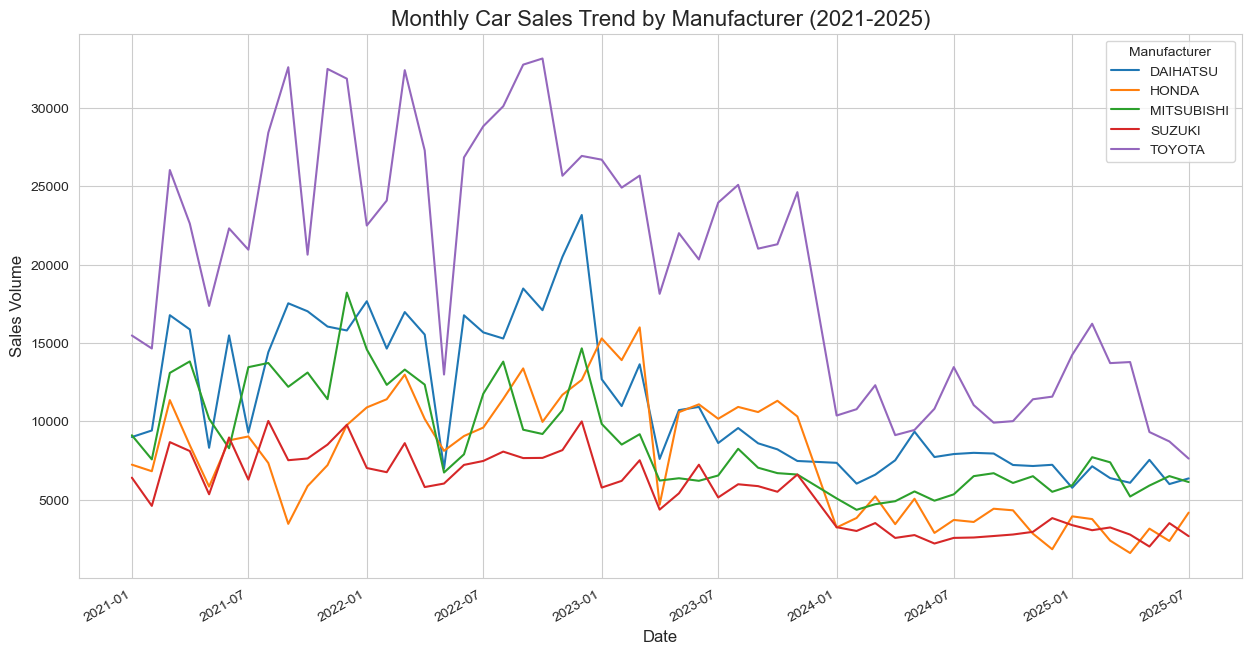

In [22]:
df.plot(figsize=(15, 8), linestyle='-')
plt.title('Monthly Car Sales Trend by Manufacturer (2021-2025)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales Volume', fontsize=12)
plt.legend(title='Manufacturer')
plt.grid(True)
plt.show()

In [23]:
# Calculate total sales to use as the target variable
df['TOTAL_SALES'] = df.sum(axis=1)

def create_features(df):
    """Function to create time-series features from a datetime index."""
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week.astype(int)

    return df

df = create_features(df)

# Define features and the target
FEATURES = ['year', 'month', 'quarter', 'dayofyear', 'weekofyear']
TARGETS = ['DAIHATSU', 'HONDA', 'MITSUBISHI', 'SUZUKI', 'TOYOTA']

for brand in TARGETS:
    df[f'{brand}_lag1'] = df[brand].shift(1)
    df[f'{brand}_lag3'] = df[brand].shift(3)
    # df[f'{brand}_lag12'] = df[brand].shift(12)
    
    # 移動平均特徴量 (過去3ヶ月と12ヶ月の平均)
    df[f'{brand}_rolling_mean3'] = df[brand].shift(1).rolling(window=3).mean()
    # df[f'{brand}_rolling_mean12'] = df[brand].shift(1).rolling(window=12).mean()
    
    # 移動標準偏差 (過去3ヶ月)
    df[f'{brand}_rolling_std3'] = df[brand].shift(1).rolling(window=3).std()
df = df.dropna()

X = df[FEATURES]
y = df[TARGETS]



print(df.head(20))


            DAIHATSU    HONDA  MITSUBISHI   SUZUKI   TOYOTA  TOTAL_SALES  \
waktu                                                                      
2021-04-01   15861.0   8474.0     13820.0   8100.0  22618.0      68873.0   
2021-05-01    8310.0   5832.0     10160.0   5341.0  17361.0      47004.0   
2021-06-01   15481.0   8782.0      8277.0   8965.0  22310.0      63815.0   
2021-07-01    9284.0   9030.0     13453.0   6274.0  20950.0      58991.0   
2021-08-01   14408.0   7337.0     13720.0  10021.0  28418.0      73904.0   
2021-09-01   17529.0   3453.0     12200.0   7515.0  32596.0      73293.0   
2021-10-01   17020.0   5861.0     13109.0   7624.0  20633.0      64247.0   
2021-11-01   16045.0   7201.0     11410.0   8512.0  32487.0      75655.0   
2021-12-01   15795.0   9759.0     18211.0   9772.0  31865.0      85402.0   
2022-01-01   17660.0  10883.0     14586.0   7017.0  22493.0      72639.0   
2022-02-01   14638.0  11407.0     12323.0   6750.0  24087.0      69205.0   
2022-03-01  

In [24]:
# --- 必要なライブラリのインポート ---
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats# --- Data Splitting ---
TRAIN_END = '2024-12-31'
X_train, y_train = X.loc[X.index <= TRAIN_END], y.loc[y.index <= TRAIN_END]
X_val, y_val = X.loc[X.index > TRAIN_END], y.loc[y.index > TRAIN_END]

print(f"Training data period: {X_train.index.min()} to {X_train.index.max()}")
print(f"Validation data period: {X_val.index.min()} to {X_val.index.max()}")

# --- パラメータチューニングとモデル学習 ---

# 1. チューニングしたいパラメータの範囲を定義
param_grid = {
    'n_estimators': stats.randint(500, 2000),
    'learning_rate': stats.uniform(0.01, 0.3),
    'max_depth': stats.randint(3, 10),
    'subsample': stats.uniform(0.6, 0.4), # 1.0までの範囲 (0.6 + 0.4)
    'colsample_bytree': stats.uniform(0.6, 0.4)
}

models = {}
for target in TARGETS:
    print(f"\nTraining and tuning XGBoost model for {target}...")
    
    # 2. XGBoostモデルを定義（GPUを有効化）
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        tree_method='hist',  # <-- GPUを有効にするための設定
        device='cuda',
        random_state=42,
        early_stopping_rounds=50
    )
    
    # 3. RandomizedSearchCV を設定
    #    n_iter: 試行回数 (多いほど良いが時間がかかる)
    #    cv: クロスバリデーションの分割数
    #    scoring: 評価指標 (ここではSMAPEの逆数を使うため 'neg_mean_absolute_percentage_error' などが候補)
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=10,  # 25通りのパラメータの組み合わせを試す
        cv=5,
        scoring='neg_root_mean_squared_error', # 評価指標としてRMSEの負の値を使用
        verbose=1,
        random_state=42,
        n_jobs=2  # 利用可能なCPUコアを全て使う
    )
    
    # 4. RandomizedSearchCV を使って最適なモデルを見つける
    #    eval_set は RandomizedSearchCV 内部のCVで使われるため、ここでは直接 fit に渡さない
    #    early_stopping を有効にするため、fit時にパラメータを渡す
    random_search.fit(X_train, y_train[target],
                      eval_set=[(X_val, y_val[target])],
                      verbose=False)
    
    # 5. 最も性能が良かったモデルを保存
    print(f"Best parameters for {target}: {random_search.best_params_}")
    models[target] = random_search.best_estimator_

Training data period: 2021-04-01 00:00:00 to 2024-12-01 00:00:00
Validation data period: 2025-01-01 00:00:00 to 2025-07-01 00:00:00

Training and tuning XGBoost model for DAIHATSU...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for DAIHATSU: {'colsample_bytree': 0.9768807022739411, 'learning_rate': 0.17898646535366178, 'max_depth': 4, 'n_estimators': 1276, 'subsample': 0.6063865008880857}

Training and tuning XGBoost model for HONDA...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for HONDA: {'colsample_bytree': 0.8404460046972835, 'learning_rate': 0.22242177333881366, 'max_depth': 8, 'n_estimators': 1832, 'subsample': 0.9879639408647978}

Training and tuning XGBoost model for MITSUBISHI...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for MITSUBISHI: {'colsample_bytree': 0.9768807022739411, 'learning_rate': 0.17898646535366178, 'max_depth': 4, 'n_estimators': 1276, 'subsample': 0.606386500888

In [25]:
# Define the SMAPE function
def smape(y_true, y_pred):
    """
    Calculates the Symmetric Mean Absolute Percentage Error (SMAPE).
    The result is returned as a percentage (e.g., 15.0 for 15%).
    """
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    # Handle the case where the denominator is zero.
    # If both true and predicted are 0, the error is 0.
    ratio = np.where(denominator == 0, 0, numerator / denominator)
    return np.mean(ratio) * 100

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

# Create a list to store the evaluation results
evaluation_results = []

# Loop through each trained model
for target, model in models.items():
    # Make predictions on the validation data
    y_pred = model.predict(X_val)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_val[target], y_pred)
    mse = mean_squared_error(y_val[target], y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val[target], y_pred)
    smape_score = smape(y_val[target], y_pred)
    
    # Store the results in a dictionary
    results = {
        'Brand': target,
        'MAE': mae,
        'RMSE': rmse,
        'R-squared': r2,
        'SMAPE (%)': smape_score  # <-- Added SMAPE here
    }
    evaluation_results.append(results)

# Convert the list of results into a pandas DataFrame
results_df = pd.DataFrame(evaluation_results)

# Display the evaluation metrics, sorted by SMAPE
print("\n--- Model Evaluation Metrics (including SMAPE) ---")
print(results_df.sort_values(by='SMAPE (%)').reset_index(drop=True))


--- Model Evaluation Metrics (including SMAPE) ---
        Brand          MAE         RMSE  R-squared  SMAPE (%)
0      SUZUKI   302.338769   419.650893   0.214519  10.713118
1  MITSUBISHI   743.068754   844.943178  -0.065507  11.542393
2    DAIHATSU  1317.854917  1423.607709  -4.702131  18.714073
3      TOYOTA  2918.781814  3075.087192  -0.000425  25.259152
4       HONDA  1201.242220  1509.794205  -1.851155  36.253885


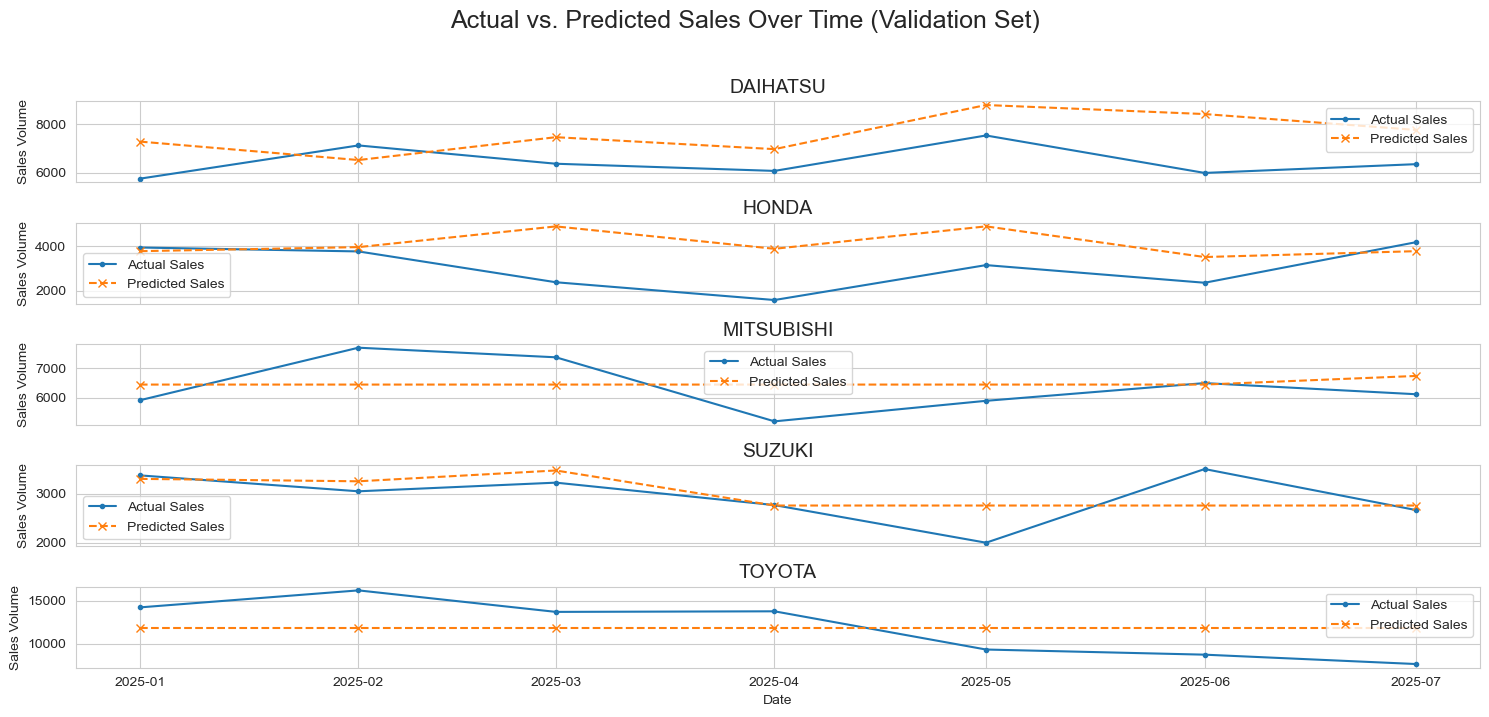

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a nice style for the plots
sns.set_style('whitegrid')

# Create subplots to visualize each model's predictions
# This will create a separate chart for each brand for clarity
fig, axes = plt.subplots(nrows=len(TARGETS), ncols=1, figsize = (15, 8), sharex=True)
fig.suptitle('Actual vs. Predicted Sales Over Time (Validation Set)', fontsize=18, y=0.92)

for i, target in enumerate(TARGETS):
    # Get the specific subplot
    ax = axes[i]
    
    # Use the trained model for the brand to make predictions
    y_pred = models[target].predict(X_val)
    
    # Plot the actual sales data from the validation set
    ax.plot(y_val.index, y_val[target], label='Actual Sales', marker='.', linestyle='-')
    
    # Plot the model's predicted sales on top
    ax.plot(y_val.index, y_pred, label='Predicted Sales', marker='x', linestyle='--')
    
    # Set titles and labels for clarity
    ax.set_title(target, fontsize=14)
    ax.set_ylabel('Sales Volume')
    ax.legend()

plt.xlabel('Date')
plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()